# 1. Import and Install Dependencies

In [2]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe scikit-learn matplotlib

In [3]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [4]:
import tensorflow as tf
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import (LSTM, Dense, Concatenate, Attention, Dropout, Softmax,
                                     Input, Flatten, Activation, Bidirectional, Permute, multiply, 
                                     ConvLSTM2D, MaxPooling3D, TimeDistributed, Conv2D, MaxPooling2D)

from scipy import stats

# disable some of the tf/keras training warnings 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
tf.get_logger().setLevel("ERROR")
tf.autograph.set_verbosity(1)

# suppress untraced functions warning
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# 2. Keypoints using MP Pose

In [5]:
mp_holistic = mp.solutions.holistic # Holistic model

# Pre-trained pose estimation model from Google Mediapipe
mp_pose = mp.solutions.pose

mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [6]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [7]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )

In [8]:
def draw_styled_landmarks(image, results): 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [274]:
cap = cv2.VideoCapture(0) # camera object
HEIGHT = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # webcam video frame height
WIDTH = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) # webcam video frame width
FPS = int(cap.get(cv2.CAP_PROP_FPS)) # webcam video fram rate 

# Set and test mediapipe model using webcam
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
      
        # Make detection
        image, results = mediapipe_detection(frame, pose)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
        except:
            pass
        
        # Render detections
        draw_landmarks(image, results)               
        
        # Display frame on screen
        cv2.imshow('OpenCV Feed', image)
        
        # Exit / break out logic
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [275]:
len(results.pose_landmarks.landmark)

33

In [276]:
results

mediapipe.python.solution_base.SolutionOutputs

In [277]:
draw_landmarks(frame, results)

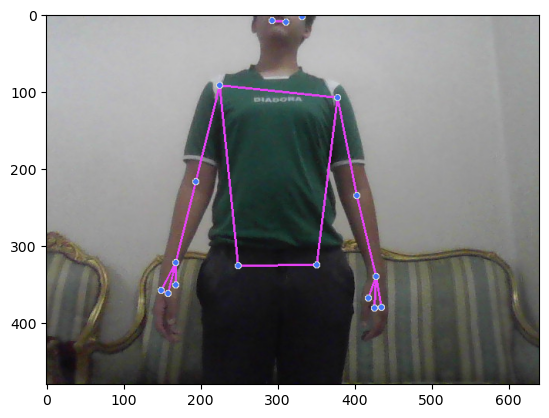

In [278]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [15]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [16]:
# 33 landmarks with 4 values (x, y, z, visibility)
num_landmarks = len(landmarks)
num_values = len(test)
num_input_values = num_landmarks*num_values

In [17]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)

In [18]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)

    return pose

In [19]:
result_test = extract_keypoints(results)

In [20]:
result_test

array([ 0.45916826,  0.09054374, -0.41901511,  0.99992788,  0.47185293,
        0.06233576, -0.39411011,  0.99985576,  0.48114243,  0.06225869,
       -0.39422864,  0.99986142,  0.48981404,  0.06259409, -0.39419317,
        0.99985248,  0.44449988,  0.06254466, -0.39539742,  0.99989748,
        0.4349885 ,  0.06306469, -0.39528441,  0.99990183,  0.42893776,
        0.06398587, -0.39545459,  0.99990606,  0.50044072,  0.07807193,
       -0.21378598,  0.99980968,  0.42118454,  0.08004868, -0.22019103,
        0.99992245,  0.47675887,  0.12559804, -0.3502976 ,  0.99992204,
        0.44362062,  0.12616429, -0.35131055,  0.99994278,  0.57014364,
        0.27664599, -0.08570197,  0.99951053,  0.36528805,  0.26712662,
       -0.14679319,  0.99989235,  0.61425549,  0.51019931,  0.00773463,
        0.97803974,  0.30602103,  0.49672958, -0.12827617,  0.98660737,
        0.72860193,  0.66484833, -0.15826009,  0.95678443,  0.19599253,
        0.66693437, -0.31581348,  0.9552756 ,  0.76719272,  0.71

In [21]:
np.save('0', result_test)

In [22]:
np.load('0.npy')

array([ 0.45916826,  0.09054374, -0.41901511,  0.99992788,  0.47185293,
        0.06233576, -0.39411011,  0.99985576,  0.48114243,  0.06225869,
       -0.39422864,  0.99986142,  0.48981404,  0.06259409, -0.39419317,
        0.99985248,  0.44449988,  0.06254466, -0.39539742,  0.99989748,
        0.4349885 ,  0.06306469, -0.39528441,  0.99990183,  0.42893776,
        0.06398587, -0.39545459,  0.99990606,  0.50044072,  0.07807193,
       -0.21378598,  0.99980968,  0.42118454,  0.08004868, -0.22019103,
        0.99992245,  0.47675887,  0.12559804, -0.3502976 ,  0.99992204,
        0.44362062,  0.12616429, -0.35131055,  0.99994278,  0.57014364,
        0.27664599, -0.08570197,  0.99951053,  0.36528805,  0.26712662,
       -0.14679319,  0.99989235,  0.61425549,  0.51019931,  0.00773463,
        0.97803974,  0.30602103,  0.49672958, -0.12827617,  0.98660737,
        0.72860193,  0.66484833, -0.15826009,  0.95678443,  0.19599253,
        0.66693437, -0.31581348,  0.9552756 ,  0.76719272,  0.71

# 4. Setup Folders for Collection

In [187]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join(os. getcwd(),'data11') 
print(DATA_PATH)

# make directory if it does not exist yet
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

# Actions/exercises that we try to detect
actions = np.array(['Side Arm Raise', 'Arm Raises'])
num_classes = len(actions)

# How many videos worth of data
no_sequences = 40

# Videos are going to be this many frames in length
sequence_length = FPS*1

# Folder start
# Change this to collect more data and not lose previously collected data
start_folder = 101

C:\Users\Dell G5 15\test\data11


In [188]:
for action in actions: 
    for sequence in range(start_folder,no_sequences+start_folder):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [189]:
# Colors associated with each exercise (e.g., curls are denoted by blue, squats are denoted by orange, etc.)
colors = [(245,117,16), (117,245,16)]

In [190]:
def calculate_angle(a,b,c):
    """
    Computes 3D joint angle inferred by 3 keypoints and their relative positions to one another
    
    """
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

In [191]:
# Collect Training Data

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    # Loop through actions
    for idx, action in enumerate(actions):
        # Loop through sequences (i.e., videos)
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length (i.e, sequence length)
            for frame_num in range(sequence_length):
                # Read feed
                ret, frame = cap.read()
                
                # Make detection
                image, results = mediapipe_detection(frame, pose)

                # Extract landmarks
                try:
                    landmarks = results.pose_landmarks.landmark

                    # Get coordinates for key joints
                    shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
                    elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
                    wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
                    
                    # Calculate angle
                    angle = calculate_angle(shoulder, elbow, wrist)
                    
                    # Visualize angle
                    cv2.putText(image, str(int(angle)), 
                                tuple(np.multiply(elbow, [640, 480]).astype(int)), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA
                                        )
                    
                except:
                    pass
                
                # Render detections
                draw_landmarks(image, results) 

                # Apply visualization logic
                if frame_num == 0: # If first frame in sequence, print that you're starting a new data collection and wait 500 ms
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    
                    cv2.putText(image, 'Collecting {} Video # {}'.format(action, sequence), (15,30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 8, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting {} Video # {}'.format(action, sequence), (15,30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, colors[idx], 4, cv2.LINE_AA)
                    
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting {} Video # {}'.format(action, sequence), (15,30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 8, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting {} Video # {}'.format(action, sequence), (15,30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, colors[idx], 4, cv2.LINE_AA)
                    
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)

                # Export keypoints (sequence + pose landmarks)
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [192]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [193]:
label_map = {label:num for num, label in enumerate(actions)}

In [194]:
label_map

{'Side Arm Raise': 0, 'Arm Raises': 1}

In [195]:
# Load and organize recorded training data
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):         
            # LSTM input data
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)  
            
        sequences.append(window)
        labels.append(label_map[action])

In [196]:
np.array(sequences).shape

(80, 30, 132)

In [197]:
np.array(labels).shape

(80,)

In [198]:
X = np.array(sequences)

In [199]:
X.shape

(80, 30, 132)

In [200]:
y = to_categorical(labels).astype(int)

In [201]:
y

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0,

In [202]:
y.shape

(80, 2)

In [203]:
# Split into training, validation, and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)
print(X_train.shape, y_train.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=15/90, random_state=2)

(72, 30, 132) (72, 2)


In [204]:
y_test.shape

(8, 2)

# 7. Build and Train LSTM Neural Network

In [205]:
# Callbacks to be used during neural network training 
es_callback = EarlyStopping(monitor='val_loss', min_delta=5e-4, patience=10, verbose=0, mode='min')
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=0, mode='min')
chkpt_callback = ModelCheckpoint(filepath=DATA_PATH, monitor='val_loss', verbose=0, save_best_only=True, 
                                 save_weights_only=False, mode='min', save_freq=1)

# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

# some hyperparamters
batch_size = 32
max_epochs = 500

In [206]:
# Set up Tensorboard logging and callbacks
NAME = f"ExerciseRecognition-LSTM-{int(time.time())}"
log_dir = os.path.join(os.getcwd(), 'logs', NAME,'')
tb_callback = TensorBoard(log_dir=log_dir)

callbacks = [tb_callback, es_callback, lr_callback, chkpt_callback]

In [207]:
lstm = Sequential()
lstm.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(sequence_length, num_input_values)))
lstm.add(LSTM(256, return_sequences=True, activation='relu'))
lstm.add(LSTM(128, return_sequences=False, activation='relu'))
lstm.add(Dense(128, activation='relu'))
lstm.add(Dense(64, activation='relu'))
lstm.add(Dense(actions.shape[0], activation='softmax'))
print(lstm.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 30, 128)           133632    
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 256)           394240    
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 130       
Total params: 749,890
Trainable params: 749,890
Non-trainable params: 0
________________________________________________

In [208]:
res = [.7, 0.2, 0.1]

In [209]:
actions[np.argmax(res)]

'Side Arm Raise'

In [210]:
lstm.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
lstm.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/500
2/2 [==============================] - 6s 2s/step - loss: 180159.5236 - categorical_accuracy: 0.5111 - val_loss: 111713.1172 - val_categorical_accuracy: 0.4167
Epoch 2/500
2/2 [==============================] - 0s 159ms/step - loss: 204161.1875 - categorical_accuracy: 0.4681 - val_loss: 2688676.0000 - val_categorical_accuracy: 0.4167
Epoch 3/500
2/2 [==============================] - 0s 159ms/step - loss: 2212887.6667 - categorical_accuracy: 0.4132 - val_loss: 730020.5000 - val_categorical_accuracy: 0.5833
Epoch 4/500
2/2 [==============================] - 0s 150ms/step - loss: 589649.8750 - categorical_accuracy: 0.6521 - val_loss: 66732.1328 - val_categorical_accuracy: 0.4167
Epoch 5/500
2/2 [==============================] - 0s 145ms/step - loss: 203811.4792 - categorical_accuracy: 0.4132 - val_loss: 95930.5000 - val_categorical_accuracy: 0.4167
Epoch 6/500
2/2 [==============================] - 0s 155ms/step - loss: 74502.7057 - categorical_accuracy: 0.5111 - val_loss: 2

In [262]:
history = lstm.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val))

Epoch 1/500
2/2 [==============================] - 0s 157ms/step - loss: 394.2987 - categorical_accuracy: 0.4833 - val_loss: 430.1727 - val_categorical_accuracy: 0.4167
Epoch 2/500
2/2 [==============================] - 0s 156ms/step - loss: 385.6395 - categorical_accuracy: 0.4833 - val_loss: 415.2381 - val_categorical_accuracy: 0.4167
Epoch 3/500
2/2 [==============================] - 0s 113ms/step - loss: 363.9976 - categorical_accuracy: 0.4833 - val_loss: 398.0718 - val_categorical_accuracy: 0.4167
Epoch 4/500
2/2 [==============================] - 0s 136ms/step - loss: 349.3170 - categorical_accuracy: 0.4833 - val_loss: 380.3926 - val_categorical_accuracy: 0.4167
Epoch 5/500
2/2 [==============================] - 0s 125ms/step - loss: 333.2557 - categorical_accuracy: 0.4833 - val_loss: 346.6021 - val_categorical_accuracy: 0.4167
Epoch 6/500
2/2 [==============================] - 0s 113ms/step - loss: 297.6806 - categorical_accuracy: 0.4833 - val_loss: 318.9025 - val_categorical_acc

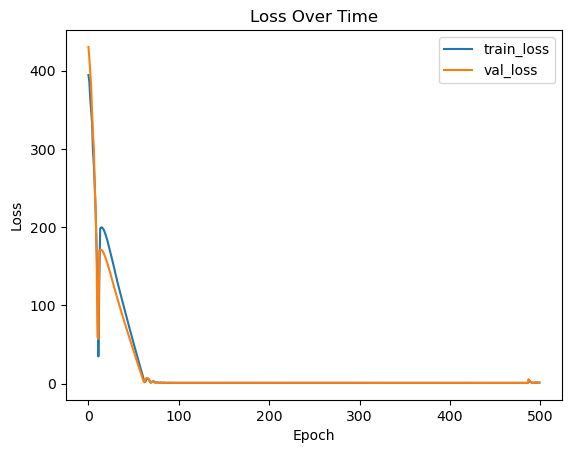

In [263]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()

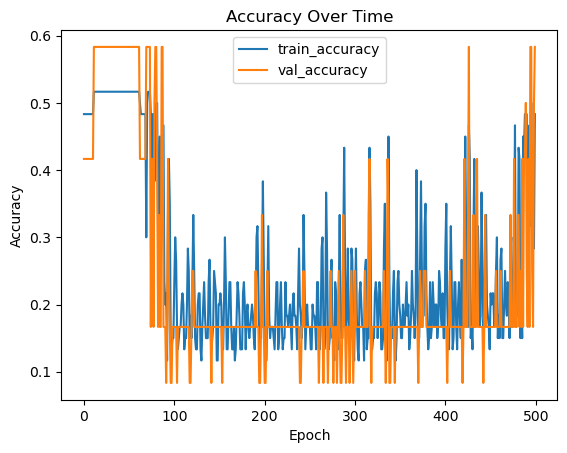

In [264]:
plt.plot(history.history['categorical_accuracy'], label='train_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.legend()
plt.show()

# 7b. LSTM + Attention

In [211]:
# Set up Tensorboard logging and callbacks
NAME = f"ExerciseRecognition-AttnLSTM-{int(time.time())}"
log_dir = os.path.join(os.getcwd(), 'logs', NAME,'')
tb_callback = TensorBoard(log_dir=log_dir)

callbacks = [tb_callback, es_callback, lr_callback, chkpt_callback]

In [212]:
def attention_block(inputs, time_steps):
    """
    Attention layer for deep neural network
    
    """
    # Attention weights
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    
    # Attention vector
    a_probs = Permute((2, 1), name='attention_vec')(a)
    
    # Luong's multiplicative score
    output_attention_mul = multiply([inputs, a_probs], name='attention_mul') 
    
    return output_attention_mul

In [213]:
HIDDEN_UNITS = 256

# Input
inputs = Input(shape=(sequence_length, num_input_values))

# Bi-LSTM
lstm_out = Bidirectional(LSTM(HIDDEN_UNITS, return_sequences=True))(inputs)

# Attention
attention_mul = attention_block(lstm_out, sequence_length)
attention_mul = Flatten()(attention_mul)

# Fully Connected Layer
x = Dense(2*HIDDEN_UNITS, activation='relu')(attention_mul)
x = Dropout(0.5)(x)

# Output
x = Dense(actions.shape[0], activation='softmax')(x)

# Bring it all together
AttnLSTM = Model(inputs=[inputs], outputs=x)
print(AttnLSTM.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 30, 132)]    0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 512)      796672      input_2[0][0]                    
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 512, 30)      0           bidirectional_1[0][0]            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 512, 30)      930         permute_1[0][0]                  
____________________________________________________________________________________________

In [214]:
AttnLSTM.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
AttnLSTM.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/500
2/2 [==============================] - 5s 1s/step - loss: 0.6912 - categorical_accuracy: 0.5431 - val_loss: 0.6597 - val_categorical_accuracy: 0.5833
Epoch 2/500
2/2 [==============================] - 0s 190ms/step - loss: 0.6642 - categorical_accuracy: 0.5424 - val_loss: 0.6087 - val_categorical_accuracy: 0.5833
Epoch 3/500
2/2 [==============================] - 0s 172ms/step - loss: 0.6294 - categorical_accuracy: 0.6229 - val_loss: 0.5144 - val_categorical_accuracy: 1.0000
Epoch 4/500
2/2 [==============================] - 0s 194ms/step - loss: 0.5277 - categorical_accuracy: 0.9007 - val_loss: 0.3252 - val_categorical_accuracy: 1.0000
Epoch 5/500
2/2 [==============================] - 0s 183ms/step - loss: 0.3324 - categorical_accuracy: 0.9889 - val_loss: 0.1661 - val_categorical_accuracy: 1.0000
Epoch 6/500
2/2 [==============================] - 0s 199ms/step - loss: 0.1883 - categorical_accuracy: 0.9889 - val_loss: 0.0258 - val_categorical_accuracy: 1.0000
Epoch 7/500
2

In [215]:
# Model map
models = {
    'LSTM': lstm, 
    'LSTM_Attention_128HUs': AttnLSTM, 
}

# 9. Save Weights

In [216]:
for model_name, model in models.items():
    save_dir = os.path.join(os.getcwd(), f"{model_name}.h5")
    model.save(save_dir)

# 9b.Load Weights

In [217]:
# Run model rebuild before doing this
for model_name, model in models.items():
    load_dir = os.path.join(os.getcwd(), f"{model_name}.h5")
    model.load_weights(load_dir)

# 9c. Make Predictions

In [218]:
for model in models.values():
    res = model.predict(X_test, verbose=0)

# 10. Evaluation using Confusion Matrix and Accuracy

In [219]:
eval_results = {}
eval_results['confusion matrix'] = None
eval_results['accuracy'] = None
eval_results['precision'] = None
eval_results['recall'] = None
eval_results['f1 score'] = None

confusion_matrices = {}
classification_accuracies = {}   
precisions = {}
recalls = {}
f1_scores = {} 

## 10a. Confusion Matrices

In [220]:
for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)
    
    # Get list of classification predictions
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    
    # Confusion matrix
    confusion_matrices[model_name] = multilabel_confusion_matrix(ytrue, yhat)
    print(f"{model_name} confusion matrix: {os.linesep}{confusion_matrices[model_name]}")

# Collect results 
eval_results['confusion matrix'] = confusion_matrices

LSTM confusion matrix: 
[[[6 0]
  [2 0]]

 [[0 2]
  [0 6]]]
LSTM_Attention_128HUs confusion matrix: 
[[[6 0]
  [0 2]]

 [[2 0]
  [0 6]]]


## 10b. Accuracy

In [221]:
for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)
    
    # Get list of classification predictions
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    
    # Model accuracy
    classification_accuracies[model_name] = accuracy_score(ytrue, yhat)    
    print(f"{model_name} classification accuracy = {round(classification_accuracies[model_name]*100,3)}%")

# Collect results 
eval_results['accuracy'] = classification_accuracies

LSTM classification accuracy = 75.0%
LSTM_Attention_128HUs classification accuracy = 100.0%


## 9c. Precision, Recall, and F1 Score

In [222]:
for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)
    
    # Get list of classification predictions
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    
    # Precision, recall, and f1 score
    report = classification_report(ytrue, yhat, target_names=actions, output_dict=True)
    
    precisions[model_name] = report['weighted avg']['precision']
    recalls[model_name] = report['weighted avg']['recall']
    f1_scores[model_name] = report['weighted avg']['f1-score'] 
   
    print(f"{model_name} weighted average precision = {round(precisions[model_name],3)}")
    print(f"{model_name} weighted average recall = {round(recalls[model_name],3)}")
    print(f"{model_name} weighted average f1-score = {round(f1_scores[model_name],3)}\n")

# Collect results 
eval_results['precision'] = precisions
eval_results['recall'] = recalls
eval_results['f1 score'] = f1_scores

LSTM weighted average precision = 0.562
LSTM weighted average recall = 0.75
LSTM weighted average f1-score = 0.643

LSTM_Attention_128HUs weighted average precision = 1.0
LSTM_Attention_128HUs weighted average recall = 1.0
LSTM_Attention_128HUs weighted average f1-score = 1.0



F:\anacondaaa2\envs\ev_8\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\anacondaaa2\envs\ev_8\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\anacondaaa2\envs\ev_8\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [223]:
accuracy_score(ytrue, yhat)

1.0

# 11. Choose Model to Test in Real Time

In [224]:
model = AttnLSTM
model_name = 'AttnLSTM'

In [271]:
#from tensorflow.keras.models import load_model

In [272]:
#model = load_model('The path of LSTM Attention model in your device')

In [1]:
#model_name = 'AttnLSTM'

In [273]:
#actions = ['Side Arm Raise', 'Arm Raises']

In [ ]:
#colors = [(245,117,16), (117,245,16)]

# 12. Test in Real Time

In [225]:
def prob_viz(res, actions, input_frame, colors):
    """
    This function displays the model prediction probability distribution over the set of exercise classes
    as a horizontal bar graph
    
    """
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):        
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [161]:
import time

In [334]:
# 1. New detection variables
sequence = []
predictions = []
res = []
threshold = 0.5 # minimum confidence to classify as an action/exercise
current_action = ''

Side_Arm_Raise_counter=0
Arm_Raises_counter=0

last_counter_time = time.time()
Wrong_counter=0
last_detected_side_arm_raise = False

# Camera object
cap = cv2.VideoCapture(0)

# Video writer object that saves a video of the real time test
fourcc = cv2.VideoWriter_fourcc('M','J','P','G') # video compression format
HEIGHT = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # webcam video frame height
WIDTH = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) # webcam video frame width
FPS = int(cap.get(cv2.CAP_PROP_FPS)) # webcam video fram rate 

video_name = os.path.join(os.getcwd(),f"{model_name}_real_time_test.avi")
out = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*"MJPG"), FPS, (WIDTH,HEIGHT))

# Set mediapipe model 
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        
        # Read feed
        ret, frame = cap.read()

        # Make detection
        image, results = mediapipe_detection(frame, pose)
        
        # Draw landmarks
        draw_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)        
        sequence.append(keypoints)      
        sequence = sequence[-sequence_length:]
              
        if len(sequence) == sequence_length:
            res = model.predict(np.expand_dims(sequence, axis=0), verbose=0)[0]           
            predictions.append(np.argmax(res))
            current_action = actions[np.argmax(res)]
            confidence = np.max(res)
            
        #3. Viz logic
            # Erase current action variable if no probability is above threshold
            #if confidence < threshold:
                #current_action = ''
            # Inside the loop:
            if confidence >= threshold:
                if time.time() - last_counter_time >= 1:
                    if current_action == 'Side Arm Raise':
                        if not last_detected_side_arm_raise:
                            Side_Arm_Raise_counter += 1
                            last_detected_side_arm_raise = True
                            last_counter_time = time.time()
                    elif current_action == 'Arm Raises':
                        if last_detected_side_arm_raise:
                            Arm_Raises_counter += 1
                            last_detected_side_arm_raise = False
                            last_counter_time = time.time()
                    else:
                        Wrong_counter += 1
                        last_counter_time = time.time()
            else:
                last_detected_side_arm_raise = False
                # Increment wrong counter if confidence is below threshold
                Wrong_counter += 1
                last_counter_time = time.time()
                    
            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
            # Count reps
            try:
                landmarks = results.pose_landmarks.landmark
                #count_reps(
                 #   image, current_action, landmarks, mp_pose)
            
                
            except:
                pass
                
            # Display graphical information
            cv2.rectangle(image, (0,0), (640, 40), colors[np.argmax(res)], -1)
            
            if current_action not in actions:
                Wrong_counter += 1
                cv2.putText(image, 'Incorrect Action '+ str(Wrong_counter), (0, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
            else:
                cv2.putText(image, 'Side_Arm_Raise ' + str(Side_Arm_Raise_counter), (3,30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                cv2.putText(image, 'Arm_Raises ' + str(Arm_Raises_counter), (325,30), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
             
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        
        # Write to video file
        if ret == True:
            out.write(image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [333]:
cap.release()
out.release()
cv2.destroyAllWindows()

In [266]:
import pkg_resources

# List all installed packages and their versions
installed_packages = pkg_resources.working_set
for package in installed_packages:
    print(package)

opencv-python 4.9.0.80
Babel 2.11.0
Bottleneck 1.3.5
Brotli 1.0.9
Jinja2 3.1.3
Keras-Applications 1.0.8
Keras-Preprocessing 1.1.2
Markdown 3.4.1
MarkupSafe 2.1.3
PyJWT 2.4.0
PyQt5 5.15.10
PyQt5-sip 12.13.0
PySocks 1.7.1
PyWavelets 1.4.1
PyYAML 6.0.1
Pygments 2.15.1
Send2Trash 1.8.2
absl-py 0.15.0
aiohttp 3.9.3
aiosignal 1.2.0
anyio 4.2.0
argon2-cffi 21.3.0
argon2-cffi-bindings 21.2.0
astor 0.8.1
asttokens 2.0.5
astunparse 1.6.3
async-lru 2.0.4
async-timeout 4.0.3
attrs 23.1.0
backcall 0.2.0
beautifulsoup4 4.12.2
bleach 4.1.0
blinker 1.6.2
bokeh 3.1.1
cachetools 4.2.2
category-encoders 2.6.3
certifi 2024.2.2
cffi 1.16.0
charset-normalizer 3.3.2
click 8.1.7
cloudpickle 2.2.1
colorama 0.4.6
comm 0.2.1
contourpy 1.0.5
cryptography 42.0.5
cycler 0.11.0
cytoolz 0.12.2
daal4py 2023.0.2
dask 2023.4.1
debugpy 1.6.7
decorator 5.1.1
defusedxml 0.7.1
exceptiongroup 1.2.0
executing 0.8.3
fastjsonschema 2.16.2
filelock 3.13.4
flatbuffers 1.12
fonttools 4.25.0
frozenlist 1.4.0
fsspec 2023.10.0
gast 0

In [267]:
pip list

Package                      Version
---------------------------- -------------------
absl-py                      0.15.0
aiohttp                      3.9.3
aiosignal                    1.2.0
anyio                        4.2.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
astor                        0.8.1
asttokens                    2.0.5
astunparse                   1.6.3
async-lru                    2.0.4
async-timeout                4.0.3
attrs                        23.1.0
Babel                        2.11.0
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       4.1.0
blinker                      1.6.2
bokeh                        3.1.1
Bottleneck                   1.3.5
Brotli                       1.0.9
cachetools                   4.2.2
category-encoders            2.6.3
certifi                      2024.2.2
cffi                         1.16.0
charset-normalizer           3.3.2
click                        